---
title: 'Lab03: Digit Recognition with Clustering'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Will Jones, Nick Sager"
date: November 9, 2023
jupyter: python3
---

## Business Understanding

The data we are working with is part of the Modified National Institute of Standards and Technology (MNIST) digit recognition dataset for computer vision. The version we are using for this project is available from on [Kaggle](https://www.kaggle.com/competitions/digit-recognizer/overview).

The MNIST dataset contains a large collection of 28x28 pixel grayscale images of handwritten digits (0 through 9). This dataset is very commonly used in machine learning, and the objective is to correctly classify the digit in each image. Identifying handwritten digits is a common problem in many business use cases; a classifier could be used to automatically read addresses on envelopes, to read handwritten numbers on bank checks for mobile deposit, or to help grade tests in an educational setting.

For this project, we set out to explore the MNIST dataset using clustering techniques. Labels are available for this data, which makes it a good candidate for many other machine learning techniques. For example, the viability of Neural Networks for classifying digits has been well documented. In practice, labelling tens of thousands of handwritten digits may time and cost prohibitive. We believe that clustering has the potential to identify groups of similar digits, which could be more easily and efficiently labelled. This would allow generalization of handwriting recognition outside of digits, and even the English language. This would be especially useful in situations where labelling is cost prohibitive, or one just wants to do a rough grouping as part of the EDA on a fresh dataset. Labelling in this way could then serve as a preprocessing step for training more complex models. 

To evaluate our clustering analysis we will primarily use clustering metrics such as RAND, adj. RAND, inertia (SSE) and silhouette score to assess the performance of different clustering methods. We will then do a visual EDA or the digits in each cluster to assess whether it looks like the algorithm is working well. Finally, we will assess the accuracy in classifying digits after labelling the clusters. Although this is not necessarily a valid metric for assessing clustering performance, it provides useful validation for using this method on unlabelled data as a preprocessing step for supervised learning. Neural Networks regularly achieve accuracies of more than 99% on this dataset [@MNIST]. We do not expect to achieve this level of accuracy, but we do expect to be able to identify clusters of digits with similar characteristics. The clusters will also be visually evaluated for separation in order to judge the feasibility of using them as a preprocessing step for other machine learning techniques.

## Data Understanding 1


The MNIST data comes in two comma separated value files for the training and test data. Each row in the files contains the label for the digit, followed by 784 columns of pixel values. The pixel values are stored as integers between 0 and 255, which represent the grayscale value of the pixel. The training data contains 42,000 records, and the test data contains 28,000 records. The test data doesn't contain labels, and is used to evaluate model performance when submitted to Kaggle.

In [1]:
import pandas as pd

# Choose File
# RawTrain = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/train.csv"
# RawTest = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/test.csv"
RawTrain = "data/train.csv"
RawTest = "data/test.csv"

# Read the CSV file
train = pd.read_csv(RawTrain)
test = pd.read_csv(RawTest)

# Get info on the train dataset
print(train.info())

# Get info on the test dataset
print(test.info())

train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


The data appears to match the description.

### Verify Data Quality:

First we will check whether there is any missing values in the dataset. If so, we will visualize where they are and how we will address them.

In [2]:
# Check whether train or test have any missing values:
print(train.isnull().any().describe())
print(test.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


There are no missing values in the dataset.

In [3]:
# Not Needed:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Heatmap for training data
# plt.figure(figsize=(12, 6))
# sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Training Data')
# plt.show()

# # Heatmap for test data
# plt.figure(figsize=(12, 6))
# sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Test Data')
# plt.show()


Next we will check if there are any duplicated records in the datasets:

In [4]:
# Check for duplicate rows
duplicates = train[train.duplicated()]
print(duplicates.info())

duplicates = test[test.duplicated()]
print(duplicates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 0.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 0.0 bytes
None


There are no duplicate rows in either dataset.

Next we will check for 'outliers'. Since the data is pixel values, we will check for values that are outside the range of 0 to 255. We will also check for unusual images by looking at the z-score of the sum of pixel values for each image. Since they are handwritten digits, we expect that the sum of pixel values will be similar for each image. Images outside of 3 standard deviations will be investigated further and may represent unusual images (e.g. images that are not digits, have colors reversed, etc.).

In [5]:
# Check whether any values are outside the range of 0 to 255:
print('Train records with value > 255:', train[train > 255].any().sum())
print('Train records with value < 0:', train[train < 0].any().sum())

print('Test records with value > 255:', test[test > 255].any().sum())
print('Test records with value < 0:', test[test < 0].any().sum())

Train records with value > 255: 0
Train records with value < 0: 0
Test records with value > 255: 0
Test records with value < 0: 0


There are no images with pixel values outside of the range of 0 to 255.

/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


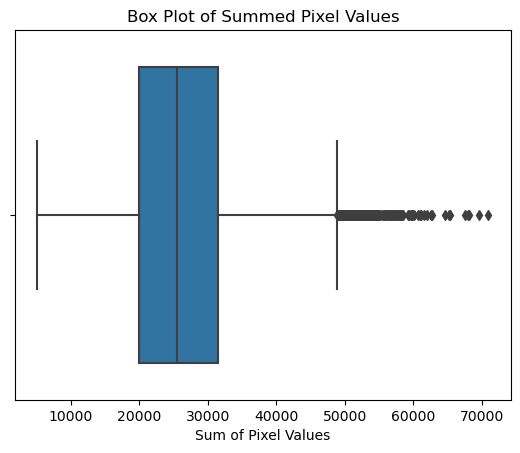

count      140.000000
mean     56014.321429
std       3808.971383
min      52092.000000
25%      53148.250000
50%      54790.000000
75%      57342.250000
max      70934.000000
dtype: float64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Calculate Z-scores for the sum of pixel values:
pixel_sum = test.iloc[1:, :].sum(axis=1)
z_scores = stats.zscore(pixel_sum)
outliers = pixel_sum[(z_scores > 3) | (z_scores < -3)]

# Plot the distribution of pixel sums:
sns.boxplot(x=pixel_sum)
plt.title('Box Plot of Summed Pixel Values')
plt.xlabel('Sum of Pixel Values')
plt.show()

print(outliers.describe())

There are 140 records with a z-score greater than 3. We will view random images from this set to see if they are unusual:

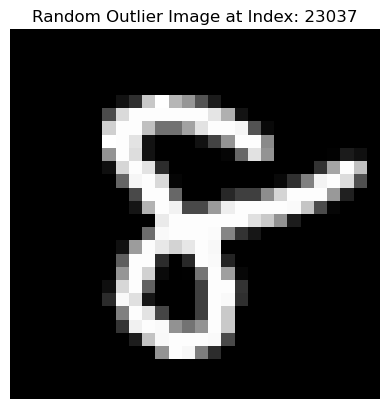

In [7]:
import matplotlib.pyplot as plt
import random

# Select a random index from the outliers
outlier_indexes = outliers.index
random_outlier_index = random.choice(outlier_indexes)

# Take the image data at the random index and reshape
image_data = train.iloc[random_outlier_index, 1:].values
image_matrix = image_data.reshape(28, 28)

# Display the image
plt.imshow(image_matrix, cmap='gray')
plt.title(f'Random Outlier Image at Index: {random_outlier_index}')
plt.axis('off')
plt.show()

The outliers all appear to be handwritten digits. There are some with especially broad strokes. Many appear to be digits with more complexity (8,3,5 for example). We will not remove these outliers.

## Data Understanding 2

To better understand the data, we will visualize some aspects. We will look at the distribution of digits within the training data. We will also view some of the images to see what they look like.

/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


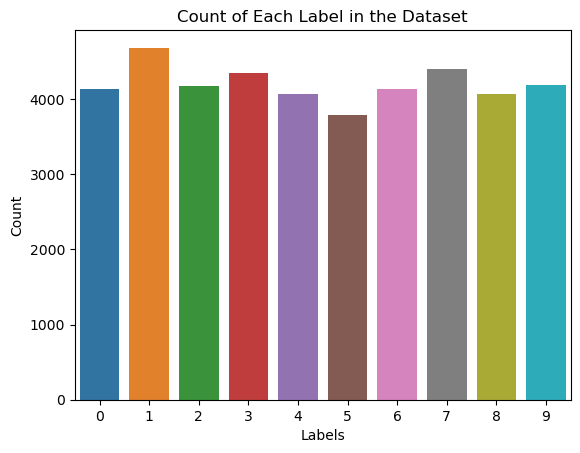

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot of digits
sns.countplot(x='label', data=train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label in the Dataset')

plt.show()


The digits in the training set appear uniformly distributed. Each label has approximately 4,000 samples or 10% of the dataset.

Here are some random images from the training set:

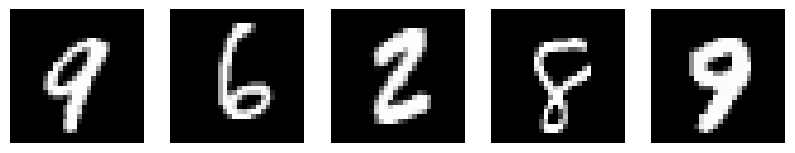

In [9]:
import numpy as np

# Display five random images from the training set:
def display_random_images(df, num_images):
    # Generate random indexes
    random_indexes = np.random.randint(0, len(df), num_images)

    # Retrieve random images by these indexes
    random_images = df.iloc[random_indexes, 1:].values

    # Reshape the random images to 28x28
    random_images = random_images.reshape(num_images, 28, 28)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

    for i in range(num_images):
        axes[i].imshow(random_images[i], cmap='gray')
        axes[i].axis('off')

    plt.show()
    
display_random_images(train, 5)

Above are five examples of what the images look like.

### Data Preparation

Next we will prepare the data for use in SciKit Learn. We will normalize the data by dividing each pixel value by 255, which will scale the values to between 0 and 1. We will also split the training set into training and validation subsets by using a Stratified Shuffle Split with 10% of the data used for validation.

In [10]:
from sklearn.model_selection import train_test_split

# Prepare the data for use in modelling:
y = train['label'].values
X = train.drop('label', axis=1).values
test_set = test.values

# Normalize the pixel data for both train and test:
X = X / 255.0
test_set = test_set / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.1, random_state=137, stratify=y)

## Modeling and Evaluation 1

Train and adjust parameters

The first thing we will do with the data is reduce the feature space using Principal Component Analysis (PCA). 784 features is fairly high. As shown below, we can explain most of the variance with just 100 principal components. Reducing the feature space will make clustering algorithms more efficient as it will reduce noise and help with the curse of dimensionality. The curse is that determining distance becomes more difficult in high-dimensional spaces because the distance between points becomes more similar as the number of dimensions increases. In addition to improving separation, reducing the feature space will also reduce the likelihood of overfitting, make some visualizations more possible, and require less processing power.

We will use the first 100 principal components in this analysis, which explains approximately 95% of the variance in the data.

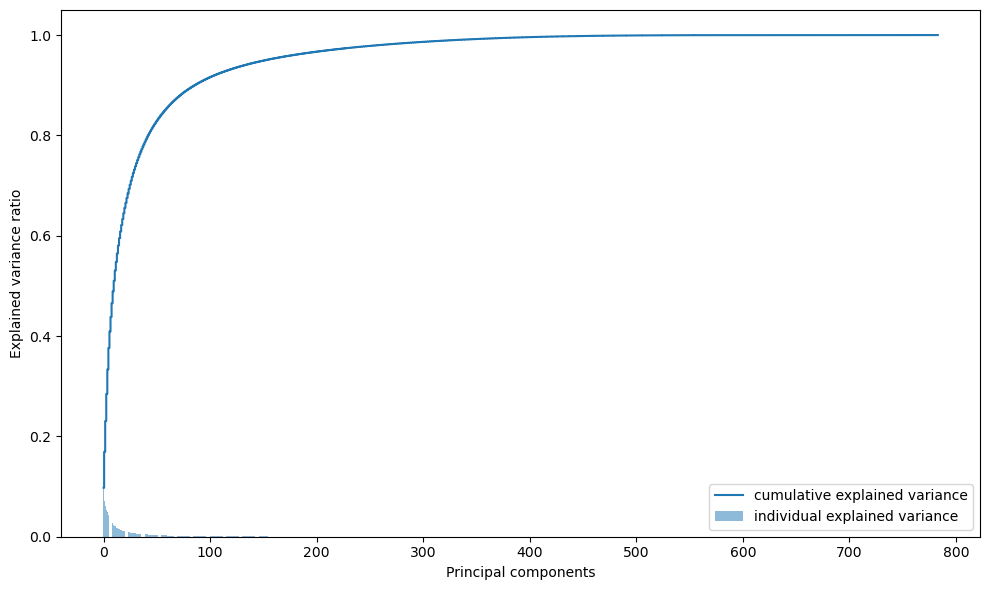

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_train)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(cum_explained_var)), cum_explained_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### KMeans Model

KMeans is a clustering method that works by randomly initializing K centroids and then iteratively updating cluster assignments for the data to maximize seperation. It is best suited for data that forms roughly spherical clusters.

Scikit-Learn's implementation of KMeans has several parameters which can take on different values. We will use a grid search to find the best parameters for our data. Because silhouette score is not natively available to tune the grid search one and we have the labels for the training data, we will use the adjusted RAND score. In an implementation where labels are truly not available, silhouette score or another alternative would be a better choice and one could implement a custom scorer.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Define the number of components for PCA and the number of clusters for KMeans
n_components = 100
n_clusters = len(np.unique(y_train))

# Create the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('algorithm', KMeans(n_clusters=n_clusters, random_state=137, n_init='auto'))
])


Here we define a parameter grid to test different configurations of KMeans:

In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'pca__n_components': [2, 10, 50, 100, 200],
    'algorithm__init': ['k-means++', 'random'],
    'algorithm__n_init': [1, 10, 20],
    'algorithm__max_iter': [50, 300, 500]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, 
                           scoring='adjusted_rand_score', 
                           cv=5, n_jobs=-1, verbose=0)


In [14]:
# Uncomment to run the grid search. Not necessary for notebook

# grid_search.fit(X_train, y_train)

In [15]:
# Uncomment to view the results of the grid search. Not necessary for notebook

# import pandas as pd

# # Extract the results from the grid search
# results = pd.DataFrame(grid_search.cv_results_)
# relevant_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
# filtered_results = results[relevant_columns]
# filtered_results = filtered_results.sort_values(by='mean_test_score', ascending=False)

# # Display the results
# pd.set_option('display.max_colwidth', None)
# print(filtered_results)

# print("Best parameters:", grid_search.best_params_)
# print("Best adjusted RAND score:", grid_search.best_score_)

There is a range of adjusted RAND scores for the parameters we have chosen. The best score is approximately 0.39, and the scores do not differ very much among the top performing configurations. In fact, the top configurations do not perform significantly differently than the default parameters for KMeans. Because this is the case, we will evaluate this algorithm on the defaults.

The grid search results do inform us on the the performance of PCA. It is clear that 2 components is not enough to achieve good clustering performance, but 50 components is on par with best results. This also suggests that since 50 components explains less variance than 100 or 200, that the algorithm is running into dimensionality issues. We will use 100 components for the remainder of the analysis.

In [16]:
# There are two options, best parameters or default settings
# Changing parameters doesn't seem to significantly change the results

# model = KMeans(init = 'random',
#                max_iter = 300,
#                n_init=1)
model = KMeans()

pipeline.set_params(pca = PCA(n_components = 100)),
pipeline.set_params(algorithm = model)

pipeline.fit(X_train)
kmeans_clusters = pipeline.predict(X_train)

kmeans_clusters

/Users/nick/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([3, 5, 4, ..., 5, 4, 3], dtype=int32)

In the next step, we will assign the cluster the value of the mode of the labels for each cluster. This somewhat artificial step will allow us to evaluate the performance of the clustering algorithm by comparing the cluster labels to the true labels later in the analysis.

In the case where there are no labels, this step would be done by visualizing the images in each cluster and manually assigning a label based on domain knowledge. We will simulate this in the visualization step, but using the mode of the labels is a good approximation.

In [17]:
km_cluster_labels = np.zeros_like(kmeans_clusters)

for cluster in range(n_clusters):
    mask = (kmeans_clusters == cluster)
    if np.any(mask):
        km_cluster_labels[mask] = mode(y_train[mask])[0]
    else:
        print(f"Cluster {cluster} is empty.")


Cluster 8 is empty.
Cluster 9 is empty.


Although we assigned 10 clusters based on our knowledge of the data, the algorithm only finds eight distinct clusters. This likely means that there isn't enough separation between some of the digits using this algorithm. We will take this into account when selecting the best clustering algorithm.

In [18]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, rand_score
# Note RAND indices are semi-cheating. They require true labels

# Calculating the silhouette score
# Note: using `clusters` skips the label assignment (semi-supervised) step
km_silhouette = silhouette_score(X_train, kmeans_clusters)
print(f"Silhouette Score: {km_silhouette:.4f}")

# RAND score
km_rand = rand_score(y_train, kmeans_clusters)
print(f"RAND Index: {km_rand:.4f}")

# Adjusted RAND score
km_adjusted_rand = adjusted_rand_score(y_train, kmeans_clusters)
print(f"Adjusted RAND Index: {km_adjusted_rand:.4f}")


Silhouette Score: 0.0731
RAND Index: 0.8748
Adjusted RAND Index: 0.3961


The KMeans algorithm performs differently depending on which metric is used. Based on RAND score, the algorithm appears close to optimal, but when controlling for chance (adjusted RAND) it does less well. That said, all three metrics are on the positive side of their ranges which suggests that this algorithm is adding value.

### Spectral Clustering Model

Spectral Clustering is a method of dividing data into similar groups using graphs. The algorithm constructs a similarity matrix based on the distance between points, and then computes the eigenvectors of the matrix. The eigenvectors represent the data in a lower-dimensional space (spectral representation), and a traditional clustering method such as kmeans is used to find clusters from the spectral representation.

This method is effective in cases where clusters are not well represented by a spherical structure. It can capture non-linear relationships and is often used in image segmentation, and graph analysis of networks. Spectral clustering is computationally intensive because of the eigenvalue decomposition and therefore doesn't scale well to large datasets. We expect this method to perform better on the MNIST dataset, but will not spend too much time on hyperparameter tuning because of the computational cost and the fact that SKLearn's implementation of Spectral Clustering does not have a predict method.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from scipy.stats import mode

# Define the number of components for PCA and the number of clusters for KMeans
n_components = 100
n_clusters = len(np.unique(y_train))

# Create the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('algorithm', SpectralClustering(n_jobs=-1, random_state=137))
])


We will define the Spectral Clustering algorithm using the default parameters. The grid search option is not available for this algorithm because it isn't meant to be used for prediction. Nested for loops could be used to evaluate different parameters, but this would be computationally expensive. Empirically, we haven't seen much improvement in clustering performance when deviating from the default parameters. We are also primarily concerned with the differences between the algorithms, and not the absolute performance of each. For these reasons, we will use the default parameters for Spectral Clustering and acknowledge that more tuning is possible once the best algorithm is selected.

In [21]:
# Takes ~ 8 minutes to run with arpack. Takes ~ 15s with amg
spc = SpectralClustering(n_clusters=n_clusters,
                         eigen_solver='amg',         # default arpack. Other options: 'lobpcg', 'amg'
                         affinity='nearest_neighbors',  # default nearest_neighbors. Other options: 'rbf'
                         assign_labels='kmeans',        # default kmeans. Other options: 'discretize', 'cluster_qr'
                         n_init=10,                     # default 10, only used for kmeans
                         n_jobs=-1, random_state=137)
pipeline.set_params(algorithm = spc)

# pipeline.fit(X_train)
spec_clusters = pipeline.fit_predict(X_train)

spec_clusters

array([4, 1, 9, ..., 1, 3, 4], dtype=int32)

As with KMeans, we will simulate visually labelling the clusters by assigning each cluster the mode of the digits it contains.

In [22]:
spec_cluster_labels = np.zeros_like(spec_clusters)

for cluster in range(n_clusters):
    mask = (spec_clusters == cluster)
    if np.any(mask):
        spec_cluster_labels[mask] = mode(y_train[mask])[0]
    else:
        print(f"Cluster {cluster} is empty.")


We will evaluate the resulting clusters using the same metrics:

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, rand_score
# Note RAND indices are semi-cheating. They require true labels

# Calculating the silhouette score
# Note: using `clusters` skips the label assignment (semi-supervised) step
spec_silhouette = silhouette_score(X_train, spec_clusters)
print(f"Silhouette Score: {spec_silhouette:.4f}")

# RAND score
spec_rand = rand_score(y_train, spec_clusters)
print(f"RAND Index: {spec_rand:.4f}")

# Adjusted RAND score
spec_adjusted_rand = adjusted_rand_score(y_train, spec_clusters)
print(f"Adjusted RAND Index: {spec_adjusted_rand:.4f}")

Silhouette Score: 0.0235
RAND Index: 0.9234
Adjusted RAND Index: 0.6192


The Spectral Clustering algorithm has a similar Silhouette score to the KMeans model. The RAND score is slightly higher, and the adjusted RAND is much higher. This suggests that the MNIST data is not well represented by spherical clusters, which is in line with what we expected. For our use case, the adjusted RAND is probably the most important clustering metric.

### DBSCAN Model

TODO: Quick EDA with DBSCAN. Cannot use to predict.

MAYBE: Add agglomerative clustering above DBSCAN.

## Modeling and Evaluation 2

Evaluate and Compare

To evaluate the clustering algorithms, we will use the silhouette score, RAND Index, and Adjusted RAND Index.

The silhouette score is the mean silhouette coefficient for all samples. The coefficient is measured by comparing the similarity (distance) of a sample to others in its cluster to that of the objects in the nearest cluster. It is a way to quantify how well-separated the clusters are, but may be misleading for high-dimensional data like the MNIST dataset is even after PCA. The metric also assumes the clusters are uniform and convex, which we have seen is not the case for the MNIST data.

The RAND Index is a measure of similarity between two data clusterings. It compares the number of pairs of samples that are assigned to the same or different clusters. In our case, we are comparing the clustering algorithms to the true labels. Adjusted RAND takes into account chance pairings and is a more rigorous metric than the RAND Index. Both indices range from -1 to 1. A score of 1 indicates perfect agreement between the two clusterings, a score of 0 indicates random chance.

Although we are evaluating the clustering algorithms for a use case where labels aren't available, it makes sense to use the labels from the MNIST dataset to compare how the methods have performed. This would be the primary metric of concern to someone using these algorithms to generate labels as a preprocessing step for supervised learning, so we will focus on the Adjusted RAND Index.

In [38]:
import numpy as np
import pandas as pd

data = {
    "Silhouette Score": [km_silhouette, spec_silhouette],
    "RAND Index": [km_rand, spec_rand],
    "Adjusted RAND Index": [km_adjusted_rand, spec_adjusted_rand]
}

df = pd.DataFrame(data, index=["KMeans", "Spectral Clustering"])

# Function to highlight the maximum in each column - GPT-4
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

styled_df = df.style.apply(highlight_max, props='color:red;', axis=0)
styled_df


,Silhouette Score,RAND Index,Adjusted RAND Index
KMeans,0.073126,0.874814,0.396076
Spectral Clustering,0.023536,0.923421,0.619192


Based on the Adjusted RAND Index, the Spectral Clustering algorithm performs the best. This makes sense, since the digits are image data and are not likely to be represented well by spherical clusters.

As discussed, using classification is better accomplished with supervised learning methods. However, since our use case involves using clustering to help generate labels for unlabeled data, it makes sense to look at accuracy to learn more about how the algorithms perform.

Our best performing clustering algorithm, Spectral Clustering, does not have the ability to make predictions on data outside the test set. We will instead define a K-Nearest Neighbors classifier using the training data and the cluster labels and use that to assign the test data to clusters. This calculation is done below using 50 nearest neighbors.

In [ ]:
# Test set accuracy of KNN prediction on Spectral Clusters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, spec_clusters)

predicted_clusters = knn.predict(X_test)

cluster_to_label_map = {}

for cluster in range(n_clusters):
    mask = (spec_clusters == cluster)
    if np.any(mask):
        # Map spectral cluster ID to its corresponding label
        cluster_to_label_map[cluster] = mode(y_train[mask])[0]

# Convert predicted cluster IDs to labels
predicted_labels = np.array([cluster_to_label_map[cluster_id] for cluster_id in predicted_clusters])

knn_spectral_accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test set Accuracy: {knn_spectral_accuracy:.4f}")

Test set Accuracy: 0.7333


Assigning the test data labels in this way results in an accuracy of 0.73. That is an admirable performance considering that the algorithm was unsupervised and the labels were generated post-hoc.

In our proposed use case, this means that the labeler could start with clusters of images that are 73% correct and realize a significant time savings over manually labeling each image. Naively, this would result in approximately a 400% increase in efficiency. This is a very rough estimate, but it does suggest that this method could be useful in practice.

To learn more about the algorithm's performance we will also look at per class accuracy:

In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
print(cm)

# Accuracy per class
class_accuracies_test = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_test):
    print(f"Accuracy for class {i}: {accuracy:.4f}")


[[404   0   0   1   1   0   2   0   5   0]
 [  0 466   1   0   0   0   0   1   0   0]
 [  3  15 380   0   2   0   1  12   5   0]
 [  2   2   2 415   1   0   0   6   7   0]
 [  2   5   0   0 396   0   0   1   3   0]
 [  0   3   0 166   6   0   9   1 195   0]
 [  3   0   0   1   2   0 394   0  14   0]
 [  0  12   0   0  17   0   0 411   0   0]
 [  0  10   0 172   8   0   1   1 214   0]
 [  5   3   0  10 324   0   0  12  65   0]]
Accuracy for class 0: 0.9782
Accuracy for class 1: 0.9957
Accuracy for class 2: 0.9091
Accuracy for class 3: 0.9540
Accuracy for class 4: 0.9730
Accuracy for class 5: 0.0000
Accuracy for class 6: 0.9517
Accuracy for class 7: 0.9341
Accuracy for class 8: 0.5271
Accuracy for class 9: 0.0000


These results suggest that some digits have a very large degree of separation and the algorithm does quite well at grouping them together. The class accuracies for '0', '1', '3', '4', and '6' are all above 95%. The algorithm does have difficulty with '5', '8', and '9', in fact failing to label any cluster as '5' or '9'.

Knowing these weak points could allow labelling efforts to be targeted toward the most difficult digits, saving further time and increasing accuracy.

## Modeling and Evaluation 3

Visualize Results

TODO: Write about visualizing results here

In [ ]:
import matplotlib.pyplot as plt
import random

# Number of images per cluster to display
num_images = 60
num_rows = 2
num_cols = num_images // num_rows

# Access the PCA component from the pipeline
pca = pipeline.named_steps['pca']

for cluster in range(n_clusters):
    # Find indexes of images in this cluster
    indexes = np.where(spec_clusters == cluster)[0]

    # Randomly select indexes
    selected_indexes = random.sample(list(indexes), min(len(indexes), num_images))

    # Plotting
    plt.figure(figsize=(20, 2))
    for i, index in enumerate(selected_indexes):
        # Retrieve the PCA-transformed data for the selected index
        pca_transformed_data = pca.transform(X_train[[index]])

        # Inverse transform to reconstruct the image
        reconstructed_image = pca.inverse_transform(pca_transformed_data)
        image_matrix = reconstructed_image.reshape(28, 28)  # Reshape

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_matrix, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Cluster {cluster} - Labeled as {spec_cluster_labels[indexes[0]]}')
    plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Scatter plot
for cluster in range(n_clusters):
    plt.scatter(X_pca[spec_clusters == cluster, 0], X_pca[spec_clusters == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization with PCA')
plt.legend()
plt.show()


## Modeling and Evaluation 4

Summarize the Ramifications

**Most Important Section**
Write more, 2x points

## Deployment

## Exceptional Work

Neural Network here for comparison purposes

## References

@misc{digit-recognizer,
    author = {AstroDave, Will Cukierski},
    title = {Digit Recognizer},
    publisher = {Kaggle},
    year = {2012},
    url = {https://kaggle.com/competitions/digit-recognizer}
}

@misc{MNIST,
    author = {Yann, LecCun, Corinna Cortes, Christopher J.C. Burges},
    title = {The MNIST Database of Handwritten Digits},
    publisher = {yan.lecun.com},
    url = {http://yann.lecun.com/exdb/mnist/}
}